<a href="https://colab.research.google.com/github/Nishanth09121996/hello-world/blob/master/Copy_of_Detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:

import torch, torchvision
torch.__version__

'1.5.1+cu101'

In [ ]:
# /!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
# !pip install -e detectron2_repo
!pip install pyyaml==5.1

In [2]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [ ]:
# download, decompress the data
!wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
!unzip data.zip > /dev/null

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")

In [5]:
fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
dataset_dicts = DatasetCatalog.get("fruits_nuts")

[07/14 04:53:58 d2.data.datasets.coco]: Loaded 18 images in COCO format from ./data/trainval.json


In [15]:
print((dataset_dicts[0].get('annotations')[0]))
print('\n')
print((dataset_dicts[0].keys()))
print('\n')
print(len(dataset_dicts))

{'iscrowd': 0, 'bbox': [101.0, 118.0, 136.0, 167.0], 'category_id': 0, 'segmentation': [[133.46583850931677, 144.3416149068323, 117.93788819875775, 169.80745341614906, 101.16770186335401, 240.61490683229812, 106.1366459627329, 267.94409937888196, 138.43478260869563, 285.3354037267081, 156.44720496894408, 283.47204968944095, 209.24223602484471, 229.43478260869563, 230.98136645962728, 209.5590062111801, 237.81366459627327, 153.03726708074532, 206.75776397515529, 120.7391304347826, 165.1428571428571, 118.87577639751552]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}


dict_keys(['file_name', 'height', 'width', 'image_id', 'annotations'])


18


In [32]:
print(len(random.sample(dataset_dicts,1)))
print(type(img))

1
<class 'numpy.ndarray'>


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



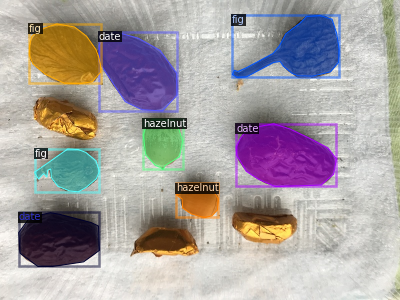

In [29]:


for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [33]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fruits_nuts",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/14 05:17:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [06:14, 475kB/s]                            
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (3,) in the model!


[07/14 05:23:31 d2.engine.train_loop]: Starting training from iteration 0
[07/14 05:23:39 d2.utils.events]:  eta: 0:01:58  iter: 19  total_loss: 2.577  loss_cls: 0.992  loss_box_reg: 0.874  loss_mask: 0.627  loss_rpn_cls: 0.019  loss_rpn_loc: 0.022  time: 0.4195  data_time: 0.0158  lr: 0.000400  max_mem: 2341M
[07/14 05:23:48 d2.utils.events]:  eta: 0:01:50  iter: 39  total_loss: 1.616  loss_cls: 0.476  loss_box_reg: 0.838  loss_mask: 0.243  loss_rpn_cls: 0.006  loss_rpn_loc: 0.020  time: 0.4195  data_time: 0.0047  lr: 0.000799  max_mem: 2341M
[07/14 05:23:56 d2.utils.events]:  eta: 0:01:41  iter: 59  total_loss: 0.750  loss_cls: 0.176  loss_box_reg: 0.441  loss_mask: 0.090  loss_rpn_cls: 0.001  loss_rpn_loc: 0.022  time: 0.4196  data_time: 0.0044  lr: 0.001199  max_mem: 2341M
[07/14 05:24:05 d2.utils.events]:  eta: 0:01:34  iter: 79  total_loss: 0.446  loss_cls: 0.094  loss_box_reg: 0.242  loss_mask: 0.069  loss_rpn_cls: 0.000  loss_rpn_loc: 0.024  time: 0.4278  data_time: 0.0046  lr:

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [34]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruits_nuts", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

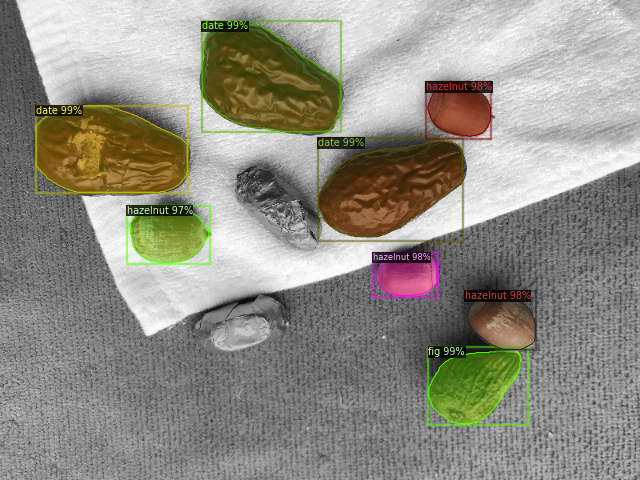

In [36]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts,1):    
    im = cv2.imread(d["file_name"])   
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [49]:
d["file_name"]

'./data/images/13.jpg'

In [ ]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='fruits_nuts', thing_classes=['date', 'fig', 'hazelnut'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.39,fps:2.59


In [50]:
!wget 'https://thumbs.dreamstime.com/b/oil-fruit-hazelnut-isolated-white-background-103521120.jpg'

--2020-07-14 05:43:12--  https://thumbs.dreamstime.com/b/oil-fruit-hazelnut-isolated-white-background-103521120.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.144.114
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.144.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39549 (39K) [image/jpeg]
Saving to: ‘oil-fruit-hazelnut-isolated-white-background-103521120.jpg’

oil-fruit-hazelnut- 100%[===================>]  38.62K  --.-KB/s    in 0s      

2020-07-14 05:43:13 (304 MB/s) - ‘oil-fruit-hazelnut-isolated-white-background-103521120.jpg’ saved [39549/39549]



In [51]:
!ls

data							    output
data.zip						    sample_data
detectron2_repo						    test_image
oil-fruit-hazelnut-isolated-white-background-103521120.jpg


In [52]:
img_smp = cv2.imread('oil-fruit-hazelnut-isolated-white-background-103521120.jpg')

In [ ]:
img_smp

In [54]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(img_smp)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.09,fps:11.40


In [ ]:
outputs

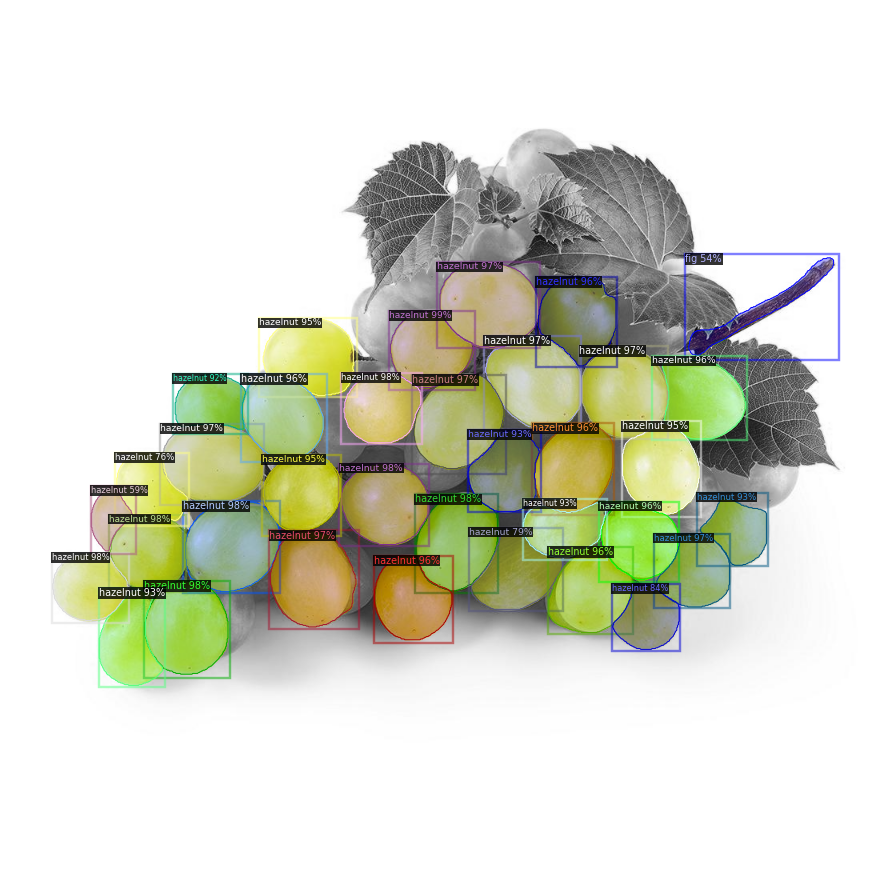

In [63]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts,1):    
    img_smp = cv2.imread('grapes.jpg')  
    outputs = predictor(img_smp)
    v = Visualizer(img_smp[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [61]:
! wget 'https://www.newsinheadlines.com/wp-content/uploads/2020/04/grapes.jpg'

--2020-07-14 05:59:24--  https://www.newsinheadlines.com/wp-content/uploads/2020/04/grapes.jpg
Resolving www.newsinheadlines.com (www.newsinheadlines.com)... 103.21.58.231
Connecting to www.newsinheadlines.com (www.newsinheadlines.com)|103.21.58.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89551 (87K) [image/jpeg]
Saving to: ‘grapes.jpg’

grapes.jpg          100%[===================>]  87.45K  --.-KB/s    in 0.1s    

2020-07-14 05:59:25 (727 KB/s) - ‘grapes.jpg’ saved [89551/89551]

